In [18]:
!pwd

/db2/users/sangwonhwang/source/galapagos_sar/scripts


In [19]:
import os
import copy
import argparse
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import pyplot as plt

from numpy import (mean,
                   std)

from scipy.stats import norm
from numpy.random import normal

%matplotlib inline

# from galapagos_comp.utils.utils import (_TP, 
#                                         _TN, 
#                                         _FP,
#                                         _FN,
#                                         get_precision,
#                                         get_recall)

# from galapagos_comp.utils.utils import pic50
# from galapagos_comp.models.lgb import run_lgb
# from galapagos_comp.models.pls import run_pls
# # from galapagos_comp.utils.calc_gold_feature import gold_decomp
# # from galapagos_comp.utils.calc_glide_feature import glide_decomp
# from galapagos_comp.utils.gen_fingerprint import interaction_fingerprint_generator

from sklearn import metrics
from sklearn.metrics import roc_auc_score


%matplotlib inline


def get_precision(_df, threshold=7):
    # TR|FP|TN|FN
    ground_positive = _df[_df['pIC50'] >= threshold]['title'].values
    predct_positive = _df[_df['rescore'] >= threshold]['title'].values

    true_positive = np.intersect1d(predct_positive, ground_positive)
    
    if len(true_positive) == 0:
        precision = 0
    else:
        # precision
        precision = len(true_positive) / (len(np.union1d(ground_positive, predct_positive)))

    return precision


def get_recall(_df, threshold=7):
    # TR|FP|TN|FN
    ground_positive = _df[_df['pIC50'] >= threshold]['title'].values
    predct_positive = _df[_df['rescore'] >= threshold]['title'].values

    true_positive = np.intersect1d(predct_positive, ground_positive)
    
    if len(true_positive) == 0:
        recall = 0
    else:
        # recall
        recall = len(true_positive) / len(ground_positive)

    return recall


def calc_auc(y_pred,y_test):
    '''
    instead of roc_auc_score
    '''
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,pos_label=1)
    return metrics.auc(fpr,tpr)


def get_result(output_dir):
    rows = list()
    frame_data_frame = pd.DataFrame()
    output = output_dir
    idx = 0
    trainset_size = 44
    
    for a_sub_dir in glob(f"{output}/*"):
        sample_id = a_sub_dir.split('/')[-2].split('_')[-1]
        pred = f'{a_sub_dir}/pred.csv'
        if os.path.exists(pred):
            fold_size = pred.split('/')[-2].split('_')[-1]
            fold_size = int(fold_size)
            pred_df = pd.read_csv(pred, index_col=False)
            if (len(set(pred_df['rescore'].values.tolist()))>1 
                and all(np.array(pred_df['rescore'].values.tolist())>0)):
                
                pred_df = pred_df.sort_values(by=['pIC50'])
                titles = pred_df['title'].values.tolist()
                titles = [title.split('|')[0] for title in titles]
                pred_df['title'] = titles
                pred_df['sample_id'] = sample_id
                pred_df['fold_size'] = fold_size
                
                _rmse = np.sqrt(((pred_df['pIC50']-pred_df['rescore']) ** 2).mean())
                pred_df['rmse'] = _rmse
                
                _precision = get_precision(pred_df)
                pred_df['precision'] = _precision
                _recall = get_recall(pred_df)
                pred_df['recall'] = _recall
                
                _corr_res = pred_df[['pIC50','rescore']].corr()
                _corr = _corr_res['rescore']['pIC50']
                pred_df['lgb_corr'] = _corr
                
                _corr_res_gold = pred_df[['pIC50','Gold.PLP.Fitness_best']].corr()
                _corr_res_gold = _corr_res_gold['Gold.PLP.Fitness_best']['pIC50']
                pred_df['gold_corr'] = _corr_res_gold

                if idx==0:
                    frame_data_frame = pred_df
                    idx=1
                else:
                    frame_list = frame_data_frame.values.tolist()
                    for a_list in pred_df.values.tolist():
                        frame_list.append(a_list)
                    frame_data_frame = pd.DataFrame(frame_list, columns = frame_data_frame.columns)

    return frame_data_frame


def res_statistics(_res_df, criteria='fold_size'):
    assert criteria in res_df.columns, f'{criteria} is not in columns!'
    rows = list()
    
    for _fs in list(set(_res_df[criteria].values.tolist())):
        _tmp_fs_df = _res_df[ _res_df[criteria]==_fs ]
        
        # corrs of samples avg.
        _lgb_corrs = [ _tmp_fs_df[_tmp_fs_df['sample_id']==s_id]['lgb_corr'].values[0] \
                       for s_id in set(_tmp_fs_df['sample_id'].values.tolist())]
        
        _lgb_corr_avg = np.array(_lgb_corrs).mean()        
        _lgb_corr_std = np.array(_lgb_corrs).std()
        _lgb_corr_var = np.array(_lgb_corrs).var()

        _gold_corr_avg = _tmp_fs_df['gold_corr'].mean()        
        _rmse_avg = _tmp_fs_df['rmse'].mean()        
        
        # total's corr
        _lgb_corr_res = _tmp_fs_df[['pIC50','rescore']].corr()
        _lgb_corr_total = _lgb_corr_res['rescore']['pIC50']

        _gold_corr_res = _tmp_fs_df[['pIC50','Gold.PLP.Fitness_best']].corr()
        _gold_corr_total = _gold_corr_res['Gold.PLP.Fitness_best']['pIC50']
        
        _rmse_total = np.sqrt(((_tmp_fs_df['pIC50']-_tmp_fs_df['rescore']) ** 2).mean())
        
        a_row = (_fs,
                 _lgb_corr_avg,
                 _lgb_corr_std,
                 _lgb_corr_var,
                 _gold_corr_avg,
                 _lgb_corr_total,
                 _gold_corr_total,
                 _rmse_avg,
                 _rmse_total)
        
        rows.append(a_row)
        
    _st_df = pd.DataFrame(data = rows,
                          columns = [f'{criteria}',
                                     'lgb_corr_samples_avg',
                                     'lgb_corr_samples_std',
                                     'lgb_corr_samples_var',
                                     'gold_corr_samples_avg',
                                     'lgb_corr_total',
                                     'gold_corr_total',
                                     'rmse_samples_avg',
                                     'rmse_total'])
    _st_df = _st_df.sort_values(by=[criteria])
    
    return _st_df


def return_lgb_plt(frame_data_frame):
    _precision = np.mean(frame_data_frame['precision'].values)
    _recall = np.mean(frame_data_frame['recall'].values)
    _corr = np.mean(frame_data_frame['lgb_corr'].values)

    xx = frame_data_frame['pIC50']
    yy = frame_data_frame['rescore']

    fp1 = np.polyfit(xx, yy, 1)
    f1 = np.poly1d(fp1)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(xx, 
               yy, 
               s=150, 
               lw=0.2, 
               alpha=0.5, 
               edgecolors='black', 
               color = '#1f77b4', 
               label='rescore/pIC50')
    ax.text(10, 
            6, 
            f'\nprecision avg. : {_precision:.3f}'+
            f'\nrecall avg. : {_recall:.3f}'+
            f'\ncorr avg. : {_corr:.3f}',
            color = '#1f77b4',
            size=10)
    ax.set_xlabel('pIC50')
    ax.set_ylabel('rescore')
    ax.legend(loc='upper right')
    plt.plot(xx, f1(xx), lw=1, color='r', label='polyfit')
    
    return plt


def return_gold_plt(frame_data_frame):
    _corr = np.mean(frame_data_frame['gold_corr'].values)
    xx = frame_data_frame['pIC50']
    yy = frame_data_frame['Gold.PLP.Fitness_best']

    fp1 = np.polyfit(xx, yy, 1)
    f1 = np.poly1d(fp1)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(xx, 
               yy, 
               s=150, 
               lw=0.2, 
               alpha=0.5, 
               edgecolors='black', 
               color = '#1f77b4', 
               label='rescore/pIC50')
    ax.text(10,
            60,
            f'\ncorr avg. : {_corr:.3f}',
            color = '#1f77b4',
            size=10)
    ax.set_xlabel('pIC50')
    ax.set_ylabel('Fitness_best')
    ax.legend(loc='upper right')
    plt.plot(xx, f1(xx), lw=2, color='r', label='polyfit')

    return plt


### feature importance avg. ###

In [8]:
df = pd.read_csv('/db2/users/sangwonhwang/source/galapagos_sar/models/lgb_gold/gold_feature_importance_avg.csv')
df[0:20]


,feature,importance
0,Gold.PLP.Chemscore.CHOScore_best,4766.20
1,Gold.Chemscore.Rot_best,3926.40
2,Gold.PLP.Fitness_best,2514.05
3,Gold.Chemscore.Fitness_best,2001.90
4,A:171:ASP:,1320.20
5,Gold.PLP.part.buried_best,1241.75
6,Gold.Chemscore.DEInternal_best,1227.70
7,A:54:LYS:,1058.60
8,Gold.PLP.part.repulsive_best,952.45
9,Gold.PLP.ligand.torsion_best,891.15


In [14]:
df = pd.read_csv('./rescore_updated.csv')
df[0:20]


,feature,importance
0,Gold.PLP.Fitness_best,6431.48
1,Gold.Chemscore.Rot_best,2072.82
2,Gold.PLP.PLP_best,1990.41
3,Gold.PLP.part.nonpolar_best,1268.85
4,Gold.PLP.ligand.torsion_best,1251.74
5,Gold.PLP.part.buried_best,1206.72
6,Gold.PLP.part.repulsive_best,1205.94
7,Gold.PLP.part.hbond_best,1171.00
8,A:32:GLY:,1052.66
9,Gold.Chemscore.Fitness_best,893.95


In [9]:
!pwd

/db2/users/sangwonhwang/source/galapagos_sar/scripts


### 1027_feature_selection_exp ###

In [21]:
for idx, a_file in enumerate(glob(f'/db2/users/sangwonhwang/source/galapagos_sar/1027_feature_selection_exp/*[0-9]/pIC50_60_3/feature_importance.csv')):
    if idx == 0:
        res_df = pd.read_csv(a_file)
    else:
        df = pd.read_csv(a_file)
        assert len(res_df) == len(df), 'different length!'
        assert (res_df['feature'].values == df['feature'].values).all, 'features are not ordered correct!'
        res_df['importance'] = (res_df['importance'] + df['importance'])

res_df['importance'] = res_df['importance'] / int(idx+1)
res_df = res_df.sort_values(['importance'], ascending=False)
# res_df.to_csv(f'./rescore_updated.csv', index=False)
ft_df_1027_500 = res_df[res_df['importance']>=500]
ft_df_1027_500


,feature,importance
0,Gold.PLP.Fitness_best,6431.48
21,Gold.Chemscore.Rot_best,2072.82
1,Gold.PLP.PLP_best,1990.41
5,Gold.PLP.part.nonpolar_best,1268.85
8,Gold.PLP.ligand.torsion_best,1251.74
4,Gold.PLP.part.buried_best,1206.72
6,Gold.PLP.part.repulsive_best,1205.94
2,Gold.PLP.part.hbond_best,1171.00
34,A:32:GLY:,1052.66
13,Gold.Chemscore.Fitness_best,893.95


### 1028_feature_selection_exp_split_set_01 ###

In [22]:
for idx, a_file in enumerate(glob(f'/db2/users/sangwonhwang/source/galapagos_sar/1028_feature_selection_exp_split_set_01/*[0-9]/pIC50_60_3/feature_importance.csv')):
    if idx == 0:
        res_df = pd.read_csv(a_file)
    else:
        df = pd.read_csv(a_file)
        assert len(res_df) == len(df), 'different length!'
        assert (res_df['feature'].values == df['feature'].values).all, 'features are not ordered correct!'
        res_df['importance'] = (res_df['importance'] + df['importance'])

res_df['importance'] = res_df['importance'] / int(idx+1)
res_df = res_df.sort_values(['importance'], ascending=False)
# res_df.to_csv(f'./rescore_updated_sw.csv', index=False)
ft_df_1028_500 = res_df


### 1101_feature_selection_exp ###

In [3]:
for idx, a_file in enumerate(glob(f'/db2/users/sangwonhwang/source/galapagos_sar/1101_feature_selection_exp/*[0-9]/pIC50_60_3/feature_importance.csv')):
    if idx == 0:
        res_df = pd.read_csv(a_file)
    else:
        df = pd.read_csv(a_file)
        assert len(res_df) == len(df), 'different length!'
        assert (res_df['feature'].values == df['feature'].values).all, 'features are not ordered correct!'
        res_df['importance'] = (res_df['importance'] + df['importance'])

res_df['importance'] = res_df['importance'] / int(idx+1)
res_df = res_df.sort_values(['importance'], ascending=False)
res_df.to_csv(f'./rescore_on_gold_term.csv', index=False)

# res_df = res_df[res_df['importance']>=500]
# ft_df_1101_500 = res_df
# ft_df_1101_500


### 1102_feature_selection_exp ###

In [2]:
for idx, a_file in enumerate(glob(f'/db2/users/sangwonhwang/source/galapagos_sar/1102_feature_selection_exp/*[0-9]/pIC50_60_3/feature_importance.csv')):
    if idx == 0:
        res_df = pd.read_csv(a_file)
    else:
        df = pd.read_csv(a_file)
        assert len(res_df) == len(df), 'different length!'
        assert (res_df['feature'].values == df['feature'].values).all, 'features are not ordered correct!'
        res_df['importance'] = (res_df['importance'] + df['importance'])

res_df['importance'] = res_df['importance'] / int(idx+1)
res_df = res_df.sort_values(['importance'], ascending=False)
# res_df.to_csv(f'./rescore_updated_sw.csv', index=False)

# res_df = res_df[res_df['importance']>=500]
ft_df_1102_500 = res_df
ft_df_1102_500


,feature,importance
0,Gold.PLP.Fitness_best,8163.70
1,Gold.PLP.PLP_best,2517.76
21,Gold.Chemscore.Rot_best,2404.04
8,Gold.PLP.ligand.torsion_best,1682.45
2,Gold.PLP.part.hbond_best,1606.62
...,...,...
61,A:215:ASP:,0.00
60,A:191:THR:,0.00
57,A:56:MET:,0.00
113,hbond_acceptorA:41:LYS:,0.00


### 1027_output_ft__10 feature importance ###

In [18]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1027_output_ft__10/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1027_output_ft__10/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df


                                        feature  importance
0              Gold.PLP.Chemscore.CHOScore_best      1888.0
1                       Gold.Chemscore.Rot_best      4537.2
2                         Gold.PLP.Fitness_best      6866.2
3                   Gold.Chemscore.Fitness_best      3017.6
4                                    A:171:ASP:         0.0
5                     Gold.PLP.part.buried_best      2812.7
6                Gold.Chemscore.DEInternal_best      2790.2
7                                     A:54:LYS:         0.0
8                  Gold.PLP.part.repulsive_best      2795.9
9                  Gold.PLP.ligand.torsion_best      3073.7
10                                   A:158:ASN:         0.0
11  Gold.PLP.Chemscore.Internal.Correction_best         0.0
12                            Gold.PLP.PLP_best      2284.7
13                  Gold.Chemscore.DEClash_best      1594.2
14                     Gold.PLP.part.hbond_best      2115.9
15                                   A:1

,sample_id,correlation,rmse,roc_auc
0,0,0.676913,1.039974,0.746667
1,1,0.781829,0.911103,0.920000
2,2,0.816230,0.775142,0.893333
3,3,0.648019,1.168371,0.800000
4,4,0.708974,0.879124,0.826667
5,5,0.689250,0.832859,0.933333
6,6,0.666458,1.018830,0.820000
7,7,0.686480,1.052997,0.893333
8,8,0.797654,0.884289,0.893333
9,9,0.701319,0.834120,0.906667


### 1027_output_ft__100 feature importance ###

In [19]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1027_output_ft__100/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1027_output_ft__100/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df


                                        feature  importance
0              Gold.PLP.Chemscore.CHOScore_best      1915.0
1                       Gold.Chemscore.Rot_best      3867.1
2                         Gold.PLP.Fitness_best      7457.7
3                   Gold.Chemscore.Fitness_best      2858.4
4                                    A:171:ASP:         0.0
5                     Gold.PLP.part.buried_best      3149.4
6                Gold.Chemscore.DEInternal_best      2773.4
7                                     A:54:LYS:         0.0
8                  Gold.PLP.part.repulsive_best      2985.1
9                  Gold.PLP.ligand.torsion_best      3091.7
10                                   A:158:ASN:         0.0
11  Gold.PLP.Chemscore.Internal.Correction_best         0.0
12                            Gold.PLP.PLP_best      3006.6
13                  Gold.Chemscore.DEClash_best      1925.6
14                     Gold.PLP.part.hbond_best      2482.5
15                                   A:1

,sample_id,correlation,rmse,roc_auc
0,0,0.564987,1.161668,0.746667
1,1,0.768230,0.921241,0.986667
2,2,0.737553,0.953727,0.866667
3,3,0.573281,1.247327,0.840000
4,4,0.626779,0.923921,0.880000
5,5,0.685560,0.814383,0.920000
6,6,0.721386,0.918370,0.860000
7,7,0.688475,1.032222,0.906667
8,8,0.810663,0.893599,0.893333
9,9,0.765910,0.783389,0.840000


### 1027_output_ft__500 feature importance ###

In [23]:
rows = list()

for sacolumnse_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1027_output_ft__500/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1027_output_ft__500/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df


                                        feature  importance
0              Gold.PLP.Chemscore.CHOScore_best      1867.2
1                       Gold.Chemscore.Rot_best      4434.8
2                         Gold.PLP.Fitness_best      6680.1
3                   Gold.Chemscore.Fitness_best      3206.6
4                                    A:171:ASP:         0.0
5                     Gold.PLP.part.buried_best      2781.4
6                Gold.Chemscore.DEInternal_best      2923.6
7                                     A:54:LYS:         0.0
8                  Gold.PLP.part.repulsive_best      3177.4
9                  Gold.PLP.ligand.torsion_best      2826.9
10                                   A:158:ASN:         0.0
11  Gold.PLP.Chemscore.Internal.Correction_best         0.0
12                            Gold.PLP.PLP_best      2829.3
13                  Gold.Chemscore.DEClash_best      1862.2
14                     Gold.PLP.part.hbond_best      2404.0
15                                   A:1

,sample_id,correlation,rmse,roc_auc
0,0,0.593470,1.125242,0.760000
1,1,0.730578,0.958067,0.933333
2,2,0.828632,0.880679,0.993333
3,3,0.717439,1.055344,0.906667
4,4,0.711792,0.812348,0.826667
5,5,0.686084,0.833524,0.933333
6,6,0.685864,0.934177,0.840000
7,7,0.651697,1.153244,0.973333
8,8,0.849269,0.815853,0.920000
9,9,0.690354,0.842849,0.866667


In [28]:
print(ft_df['feature'])
print(ft_df_1028_500['feature'])

0                Gold.PLP.Chemscore.CHOScore_best
1                         Gold.Chemscore.Rot_best
2                           Gold.PLP.Fitness_best
3                     Gold.Chemscore.Fitness_best
4                                      A:171:ASP:
5                       Gold.PLP.part.buried_best
6                  Gold.Chemscore.DEInternal_best
7                                       A:54:LYS:
8                    Gold.PLP.part.repulsive_best
9                    Gold.PLP.ligand.torsion_best
10                                     A:158:ASN:
11    Gold.PLP.Chemscore.Internal.Correction_best
12                              Gold.PLP.PLP_best
13                    Gold.Chemscore.DEClash_best
14                       Gold.PLP.part.hbond_best
15                                     A:110:ALA:
16                                      A:41:LYS:
17                                      A:33:ASN:
Name: feature, dtype: object
0            Gold.PLP.Fitness_best
21         Gold.Chemscore.Rot_best
1

### 1027_output_ft__1000 feature importance ###

In [21]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1027_output_ft__1000/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1027_output_ft__1000/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df


                                        feature  importance
0              Gold.PLP.Chemscore.CHOScore_best      2127.0
1                       Gold.Chemscore.Rot_best      4676.1
2                         Gold.PLP.Fitness_best      7370.5
3                   Gold.Chemscore.Fitness_best      3062.0
4                                    A:171:ASP:         0.0
5                     Gold.PLP.part.buried_best      3031.2
6                Gold.Chemscore.DEInternal_best      3380.1
7                                     A:54:LYS:         0.0
8                  Gold.PLP.part.repulsive_best      3079.6
9                  Gold.PLP.ligand.torsion_best      3267.4
10                                   A:158:ASN:         0.0
11  Gold.PLP.Chemscore.Internal.Correction_best         0.0
12                            Gold.PLP.PLP_best      2896.9
13                  Gold.Chemscore.DEClash_best      1843.8
14                     Gold.PLP.part.hbond_best      2812.0
15                                   A:1

,sample_id,correlation,rmse,roc_auc
0,0,0.546193,1.216987,0.666667
1,1,0.758761,1.020493,0.946667
2,2,0.782636,0.785718,0.906667
3,3,0.665381,1.178828,0.826667
4,4,0.724647,0.792878,0.853333
5,5,0.776751,0.738424,0.933333
6,6,0.649735,0.976120,0.826667
7,7,0.680504,1.034524,0.893333
8,8,0.830545,0.765540,0.893333
9,9,0.735124,0.791791,0.906667


### 1028_output_ft__10 feature importance ###

In [9]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__10/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__10/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df


                         feature  importance
0          Gold.PLP.Fitness_best      4876.5
1        Gold.Chemscore.Rot_best      2363.0
2              Gold.PLP.PLP_best      1987.8
3    Gold.PLP.part.nonpolar_best      1788.9
4   Gold.PLP.ligand.torsion_best      1332.6
..                           ...         ...
58                    A:155:LYS:        28.3
59      hbond_acceptorA:158:ASN:        16.0
60                    A:159:VAL:        18.5
61                     A:40:TYR:        55.4
62                    A:118:LYS:         1.9

[63 rows x 2 columns]
sample_id      4.500000
correlation    0.653045
rmse           1.006955
roc_auc        0.848000
dtype: float64


,sample_id,correlation,rmse,roc_auc
0,0,0.646659,1.092723,0.786667
1,1,0.766225,0.964954,0.960000
2,2,0.853173,0.747603,1.000000
3,3,0.458788,1.343285,0.786667
4,4,0.589956,0.923871,0.680000
5,5,0.698911,0.936874,0.920000
6,6,0.681050,1.004765,0.800000
7,7,0.600106,1.107997,0.866667
8,8,0.676810,0.977548,0.906667
9,9,0.558769,0.969933,0.773333


### 1028_output_ft__10 feature importance ###

In [9]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__10/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__10/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df


                         feature  importance
0          Gold.PLP.Fitness_best      4876.5
1        Gold.Chemscore.Rot_best      2363.0
2              Gold.PLP.PLP_best      1987.8
3    Gold.PLP.part.nonpolar_best      1788.9
4   Gold.PLP.ligand.torsion_best      1332.6
..                           ...         ...
58                    A:155:LYS:        28.3
59      hbond_acceptorA:158:ASN:        16.0
60                    A:159:VAL:        18.5
61                     A:40:TYR:        55.4
62                    A:118:LYS:         1.9

[63 rows x 2 columns]
sample_id      4.500000
correlation    0.653045
rmse           1.006955
roc_auc        0.848000
dtype: float64


,sample_id,correlation,rmse,roc_auc
0,0,0.646659,1.092723,0.786667
1,1,0.766225,0.964954,0.960000
2,2,0.853173,0.747603,1.000000
3,3,0.458788,1.343285,0.786667
4,4,0.589956,0.923871,0.680000
5,5,0.698911,0.936874,0.920000
6,6,0.681050,1.004765,0.800000
7,7,0.600106,1.107997,0.866667
8,8,0.676810,0.977548,0.906667
9,9,0.558769,0.969933,0.773333


### 1028_output_ft__100 feature importance ###

In [17]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__100/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__100/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df.sort_values(by=['importance'], ascending=False))
print(df.mean())
df


                             feature  importance
0              Gold.PLP.Fitness_best      4746.6
1            Gold.Chemscore.Rot_best      2427.9
2                  Gold.PLP.PLP_best      1461.3
3        Gold.PLP.part.nonpolar_best      1356.6
4       Gold.PLP.ligand.torsion_best      1081.9
17                        A:112:SER:      1063.8
6       Gold.PLP.part.repulsive_best      1039.4
5          Gold.PLP.part.buried_best       915.3
33                        A:170:VAL:       839.2
25                        A:157:GLN:       832.3
13    Gold.Chemscore.DEInternal_best       813.0
12                        A:115:ASP:       779.1
35                         A:83:ALA:       747.4
7           Gold.PLP.part.hbond_best       720.0
9        Gold.Chemscore.Fitness_best       693.0
21                        A:160:LEU:       683.8
28                        A:107:PHE:       606.1
8                          A:32:GLY:       567.4
10                         A:39:VAL:       543.5
27                  

,sample_id,correlation,rmse,roc_auc
0,0,0.523639,1.193999,0.706667
1,1,0.738172,0.970901,0.920000
2,2,0.792238,0.836929,0.933333
3,3,0.487812,1.343946,0.693333
4,4,0.483503,1.039534,0.666667
5,5,0.697023,0.818469,0.920000
6,6,0.461814,1.103457,0.666667
7,7,0.583933,1.125740,0.866667
8,8,0.649833,0.970143,0.800000
9,9,0.506945,0.997589,0.706667


### 1028_output_ft__500 feature importance ###

In [49]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__500/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__500/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])
ft_df = ft_df.sort_values(by=['importance'], ascending=False)
print(ft_df)
print(df.mean())
df


                             feature  importance
0              Gold.PLP.Fitness_best      5807.4
1            Gold.Chemscore.Rot_best      2164.4
2                  Gold.PLP.PLP_best      2034.3
6       Gold.PLP.part.repulsive_best      1758.1
3        Gold.PLP.part.nonpolar_best      1676.4
4       Gold.PLP.ligand.torsion_best      1580.8
25                        A:157:GLN:      1443.2
5          Gold.PLP.part.buried_best      1391.2
12                        A:115:ASP:      1369.1
17                        A:112:SER:      1348.2
7           Gold.PLP.part.hbond_best      1097.1
10                         A:39:VAL:      1036.0
21                        A:160:LEU:       991.3
26                         A:31:VAL:       953.0
13    Gold.Chemscore.DEInternal_best       877.1
9        Gold.Chemscore.Fitness_best       871.8
16          Gold.Chemscore.Lipo_best       835.6
8                          A:32:GLY:       820.7
14         Gold.Chemscore.Hbond_best       802.8
27                  

,sample_id,correlation,rmse,roc_auc
0,0,0.648005,1.091039,0.746667
1,1,0.767323,0.943927,0.946667
2,2,0.787173,0.857293,0.893333
3,3,0.531860,1.275691,0.786667
4,4,0.633768,0.890668,0.813333
5,5,0.733902,0.778321,0.933333
6,6,0.615308,1.008619,0.733333
7,7,0.772914,0.918903,0.960000
8,8,0.654696,1.008457,0.853333
9,9,0.621782,0.919122,0.826667


In [57]:
ft_df_ft_vals = ft_df['feature'].values
print(len(ft_df_ft_vals))

rescore_updated_df = pd.read_csv('./rescore_updated.csv')
rescore_updated_df_ft_vals = rescore_updated_df[rescore_updated_df['importance']>=500]['feature'].values
print(len(rescore_updated_df_ft_vals))

intersection = list(set(ft_df_ft_vals) & set(rescore_updated_df_ft_vals))
print(len(intersection))




28
28
28


In [62]:
intersection = list(set(ft_df_ft_vals) & set(ft_df_1028_500['feature'].values))
print(len(intersection))
intersection

19


['Gold.Chemscore.Hbond_best',
 'Gold.Chemscore.Rot_best',
 'Gold.Chemscore.DEInternal_best',
 'Gold.PLP.ligand.torsion_best',
 'Gold.PLP.part.hbond_best',
 'Gold.PLP.Chemscore.CHOScore_best',
 'A:32:GLY:',
 'A:34:GLY:',
 'Gold.Chemscore.DEClash_best',
 'Gold.PLP.part.nonpolar_best',
 'Gold.PLP.Fitness_best',
 'Gold.PLP.part.repulsive_best',
 'Gold.Chemscore.DG_best',
 'A:158:ASN:',
 'A:112:SER:',
 'Gold.Chemscore.Fitness_best',
 'Gold.PLP.part.buried_best',
 'Gold.PLP.PLP_best',
 'hbond_acceptorA:108:CYS:']

In [58]:
intersection = list(set(ft_df['feature'].values) & set(ft_df_1028_500['feature'].values))
print(len(intersection))
print(len(set(ft_df['feature'].values)))


19
28


In [43]:
rescore_updated_df = pd.read_csv('./rescore_updated.csv')


In [46]:
intersection = list(set(rescore_updated_df_ft_vals) & set(ft_df_1028_500['feature'].values))
len(intersection)



28

In [45]:
rescore_updated_df = rescore_updated_df[rescore_updated_df['importance']>=500].sort_values(by=['importance'], ascending=False)
rescore_updated_df.
ft_df_1028_500['feature'].values


,feature,importance
0,Gold.PLP.Fitness_best,6431.48
1,Gold.Chemscore.Rot_best,2072.82
2,Gold.PLP.PLP_best,1990.41
3,Gold.PLP.part.nonpolar_best,1268.85
4,Gold.PLP.ligand.torsion_best,1251.74
5,Gold.PLP.part.buried_best,1206.72
6,Gold.PLP.part.repulsive_best,1205.94
7,Gold.PLP.part.hbond_best,1171.00
8,A:32:GLY:,1052.66
9,Gold.Chemscore.Fitness_best,893.95


In [47]:
len(rescore_updated_df)

28

### 1028_output_ft__1000 feature importance ###

In [15]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__1000/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__1000/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df.sort_values(by=['importance'], ascending=False))
print(df.mean())
df


                        feature  importance
0         Gold.PLP.Fitness_best      8037.9
1       Gold.Chemscore.Rot_best      5636.5
6  Gold.PLP.part.repulsive_best      4821.5
5     Gold.PLP.part.buried_best      4522.2
4  Gold.PLP.ligand.torsion_best      4487.3
3   Gold.PLP.part.nonpolar_best      4446.8
2             Gold.PLP.PLP_best      4184.6
7      Gold.PLP.part.hbond_best      3626.6
8                     A:32:GLY:      3595.8
sample_id      4.500000
correlation    0.664083
rmse           0.949363
roc_auc        0.860667
dtype: float64


,sample_id,correlation,rmse,roc_auc
0,0,0.372627,1.248451,0.680000
1,1,0.694554,0.992332,0.986667
2,2,0.804514,0.745464,0.933333
3,3,0.565670,1.248335,0.853333
4,4,0.593361,0.934943,0.700000
5,5,0.693358,0.822751,0.933333
6,6,0.732206,0.870488,0.853333
7,7,0.665719,1.051916,0.866667
8,8,0.822532,0.746242,0.906667
9,9,0.696284,0.832704,0.893333


### 1102_output_ft__10_gold_term trained model ###

In [5]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__10_gold_term/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__10_gold_term/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df
    

                             feature  importance
0              Gold.PLP.Fitness_best      4691.4
1                  Gold.PLP.PLP_best      2084.6
2       Gold.PLP.part.repulsive_best      2020.7
3          Gold.PLP.part.buried_best      1702.1
4       Gold.PLP.ligand.torsion_best      1720.1
5           Gold.PLP.part.hbond_best      1679.6
6        Gold.Chemscore.Fitness_best      1180.5
7          Gold.Chemscore.Hbond_best      1222.5
8        Gold.PLP.part.nonpolar_best      1533.1
9     Gold.Chemscore.DEInternal_best      1651.0
10       Gold.Chemscore.DEClash_best       892.4
11          Gold.Chemscore.Lipo_best      1124.6
12            Gold.Chemscore.DG_best       681.0
13  Gold.PLP.Chemscore.CHOScore_best       854.7
14     Gold.PLP.Chemscore.Hbond_best       458.2
sample_id      4.500000
correlation    0.646562
rmse           1.018588
roc_auc        0.831333
dtype: float64


,sample_id,correlation,rmse,roc_auc
0,0,0.490834,1.188136,0.666667
1,1,0.749917,0.935422,0.973333
2,2,0.730972,0.947798,0.960000
3,3,0.552280,1.323475,0.766667
4,4,0.575048,0.948468,0.720000
5,5,0.514257,0.974063,0.826667
6,6,0.706767,0.944486,0.720000
7,7,0.618620,1.118807,0.906667
8,8,0.687441,0.930310,0.813333
9,9,0.839485,0.874915,0.960000


### 1102_output_ft__100_gold_term trained model ###

In [6]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__100_gold_term/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__100_gold_term/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df
    

                             feature  importance
0              Gold.PLP.Fitness_best      3401.0
1                  Gold.PLP.PLP_best      1855.2
2       Gold.PLP.part.repulsive_best      1210.4
3          Gold.PLP.part.buried_best      1386.5
4       Gold.PLP.ligand.torsion_best      1049.0
5           Gold.PLP.part.hbond_best      1141.9
6        Gold.Chemscore.Fitness_best       805.5
7          Gold.Chemscore.Hbond_best      1003.6
8        Gold.PLP.part.nonpolar_best      1402.1
9     Gold.Chemscore.DEInternal_best       982.3
10       Gold.Chemscore.DEClash_best       610.7
11          Gold.Chemscore.Lipo_best       918.8
12            Gold.Chemscore.DG_best       532.0
13  Gold.PLP.Chemscore.CHOScore_best       826.5
14     Gold.PLP.Chemscore.Hbond_best       313.2
sample_id      4.500000
correlation    0.645806
rmse           1.000896
roc_auc        0.842000
dtype: float64


,sample_id,correlation,rmse,roc_auc
0,0,0.390776,1.248163,0.653333
1,1,0.698047,0.978568,0.973333
2,2,0.770888,0.793257,0.906667
3,3,0.503822,1.271967,0.780000
4,4,0.529056,1.026122,0.760000
5,5,0.683641,0.819753,0.866667
6,6,0.659930,0.970609,0.733333
7,7,0.611477,1.115088,0.906667
8,8,0.813604,0.872288,0.946667
9,9,0.796820,0.913145,0.893333


### 1102_output_ft__500_gold_term trained model ###

In [7]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__500_gold_term/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__500_gold_term/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df
    

                             feature  importance
0              Gold.PLP.Fitness_best      4574.3
1                  Gold.PLP.PLP_best      2152.1
2       Gold.PLP.part.repulsive_best      2424.7
3          Gold.PLP.part.buried_best      1817.8
4       Gold.PLP.ligand.torsion_best      1792.0
5           Gold.PLP.part.hbond_best      1998.9
6        Gold.Chemscore.Fitness_best      1399.6
7          Gold.Chemscore.Hbond_best      1411.1
8        Gold.PLP.part.nonpolar_best      1656.4
9     Gold.Chemscore.DEInternal_best      1360.1
10       Gold.Chemscore.DEClash_best       834.1
11          Gold.Chemscore.Lipo_best      1420.4
12            Gold.Chemscore.DG_best       631.1
13  Gold.PLP.Chemscore.CHOScore_best       937.9
14     Gold.PLP.Chemscore.Hbond_best       611.2
sample_id      4.500000
correlation    0.655607
rmse           1.003484
roc_auc        0.858000
dtype: float64


,sample_id,correlation,rmse,roc_auc
0,0,0.546220,1.187343,0.720000
1,1,0.720651,0.949820,0.960000
2,2,0.790470,0.861259,0.973333
3,3,0.466254,1.361945,0.780000
4,4,0.601063,0.927652,0.826667
5,5,0.504092,0.978572,0.893333
6,6,0.701466,0.939414,0.706667
7,7,0.638206,1.092550,0.920000
8,8,0.778907,0.924834,0.853333
9,9,0.808743,0.811451,0.946667


### 1102_output_ft__1000_gold_term trained model ###

In [8]:
rows = list()

for sample_id in range(0, 10):
    a_pred = f"/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__1000_gold_term/{sample_id}/pred.csv"
    a_ft_m = f"/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__1000_gold_term/{sample_id}/feature_importance.csv"

    # feature importance
    if sample_id == 0:
        ft_df = pd.read_csv(a_ft_m)
    else:
        _ft_df = pd.read_csv(a_ft_m)
        assert len(ft_df) == len(_ft_df), 'different length!'
        assert (ft_df['feature'].values == _ft_df['feature'].values).all, 'features are not ordered correct!'
        ft_df['importance'] = (ft_df['importance'] + _ft_df['importance'])
    
    # auc
    if not os.path.exists(a_pred):
        print(f'{a_pred} does not exist!')
    pred_df = pd.read_csv(a_pred)

    if len(set(pred_df['rescore'].values.tolist())) > 1:
        _tmpdf = copy.deepcopy(pred_df)
        corr_res = _tmpdf[['pIC50','rescore']].corr()
        corr = corr_res['rescore']['pIC50']
        rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        a_row = (sample_id, corr, rmse, roc_auc)
        rows.append(a_row)

# feature importance
ft_df['importance'] = ft_df['importance'] / int(sample_id+1)
# auc
df = pd.DataFrame(data= rows,
                  columns= ['sample_id',
                            'correlation', 
                            'rmse',
                            'roc_auc'])

print(ft_df)
print(df.mean())
df
    

                             feature  importance
0              Gold.PLP.Fitness_best      5722.0
1                  Gold.PLP.PLP_best      2299.4
2       Gold.PLP.part.repulsive_best      2724.4
3          Gold.PLP.part.buried_best      2041.7
4       Gold.PLP.ligand.torsion_best      2267.5
5           Gold.PLP.part.hbond_best      1852.3
6        Gold.Chemscore.Fitness_best      1879.9
7          Gold.Chemscore.Hbond_best      1457.2
8        Gold.PLP.part.nonpolar_best      2020.6
9     Gold.Chemscore.DEInternal_best      1686.3
10       Gold.Chemscore.DEClash_best      1261.6
11          Gold.Chemscore.Lipo_best      1221.4
12            Gold.Chemscore.DG_best      1310.4
13  Gold.PLP.Chemscore.CHOScore_best      1120.7
sample_id      4.500000
correlation    0.630441
rmse           1.008391
roc_auc        0.815333
dtype: float64


,sample_id,correlation,rmse,roc_auc
0,0,0.423516,1.226729,0.546667
1,1,0.749305,0.983204,0.973333
2,2,0.611076,0.970675,0.740000
3,3,0.545057,1.259098,0.793333
4,4,0.599382,0.929345,0.746667
5,5,0.652410,0.878324,0.920000
6,6,0.639311,0.993916,0.793333
7,7,0.581376,1.138233,0.866667
8,8,0.778370,0.847597,0.866667
9,9,0.724609,0.856784,0.906667


In [9]:
___df = pd.read_csv(f'/db2/users/sangwonhwang/source/galapagos_sar/models/lgb_gold_scaled_dock/gold_feature_importance_avg.csv')

In [10]:
___df

,feature,importance
0,Gold.PLP.Fitness_best,8237.11
1,Gold.PLP.PLP_best,3611.89
2,Gold.PLP.part.repulsive_best,3534.87
3,Gold.PLP.part.buried_best,3498.34
4,Gold.PLP.ligand.torsion_best,3049.57
5,Gold.PLP.part.hbond_best,2741.48
6,Gold.Chemscore.Fitness_best,2502.60
7,Gold.Chemscore.Hbond_best,2215.67
8,Gold.PLP.part.nonpolar_best,2135.51
9,Gold.Chemscore.DEInternal_best,2105.04


### 1028 ###
### /db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__10 ###

In [31]:
output_dir = '/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__500_gold_term'
res_df = get_result(output_dir)
# res_statistics(res_df, criteria='fold_size')


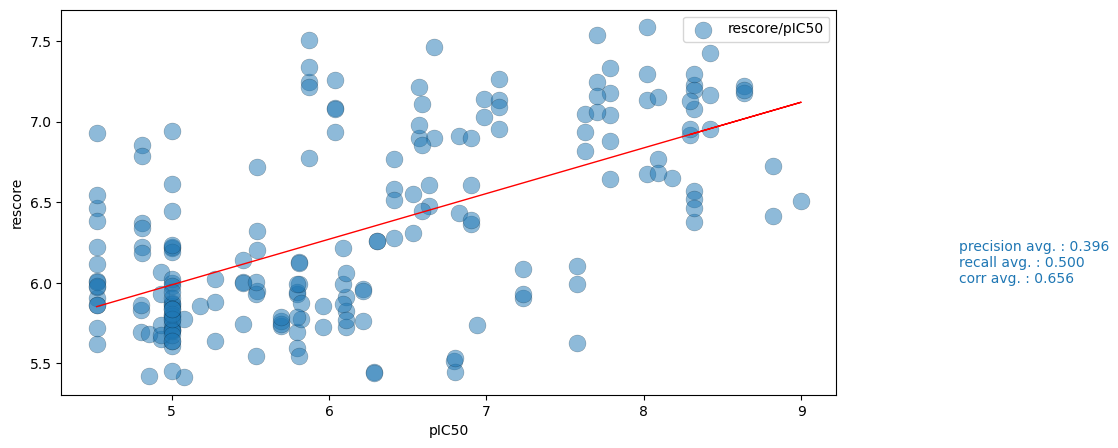

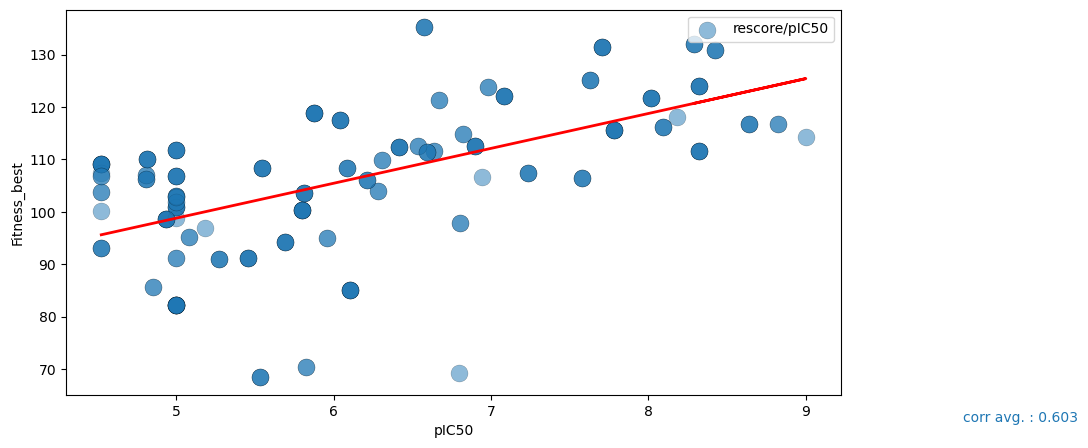

In [32]:
_plt_lgb = return_lgb_plt(res_df)
_plt_lgb.show()
_plt_gold = return_gold_plt(res_df)
_plt_gold.show()


### 1028 ###
### /db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__500 ###

In [20]:
output_dir = '/db2/users/sangwonhwang/source/galapagos_sar/1028_output_ft__500'
res_df = get_result(output_dir)
# res_statistics(res_df, criteria='fold_size')


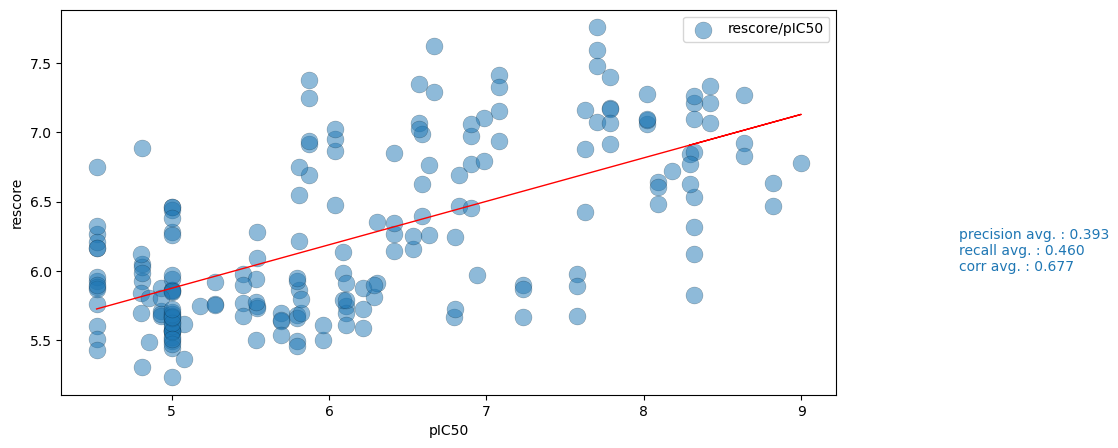

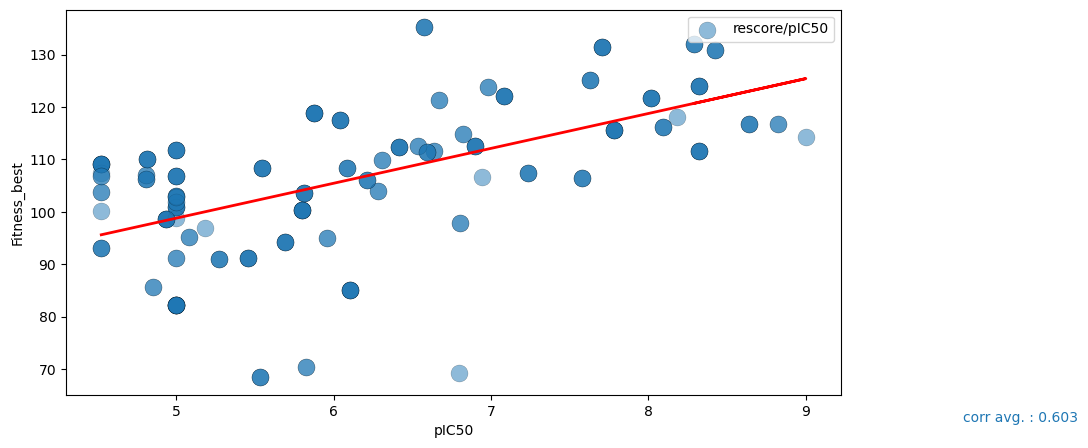

In [22]:
_plt_lgb = return_lgb_plt(res_df)
_plt_lgb.show()
_plt_gold = return_gold_plt(res_df)
_plt_gold.show()


### 1102_output_ft__500_gold_term ###
### /db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0731 ###

In [23]:
output_dir = '/db2/users/sangwonhwang/source/galapagos_sar/1102_output_ft__500_gold_term'
res_df = get_result(output_dir)


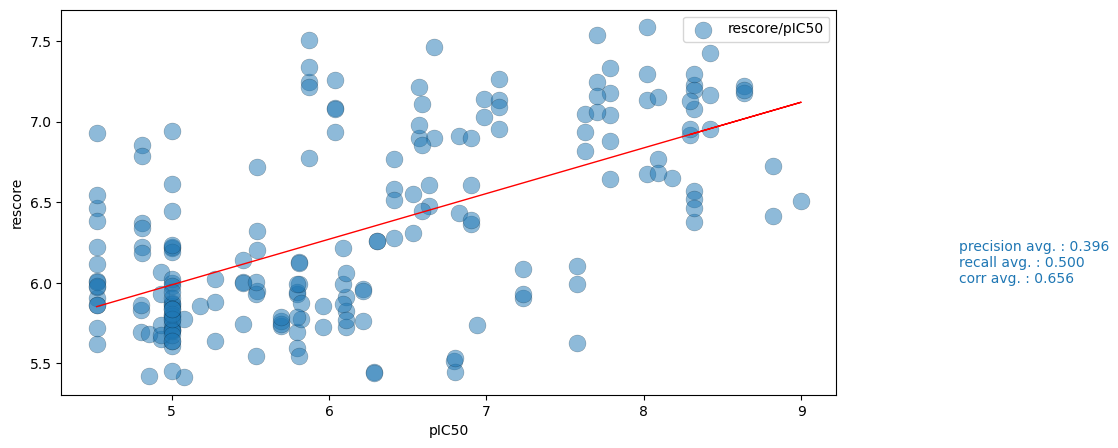

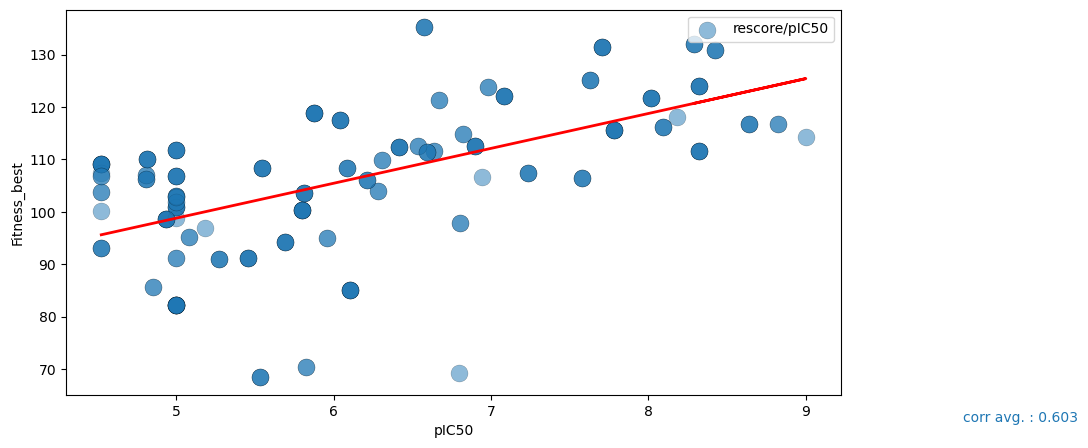

In [24]:
_plt_lgb = return_lgb_plt(res_df)
_plt_lgb.show()
_plt_gold = return_gold_plt(res_df)
_plt_gold.show()


### 0731(date) 44(trainsetsize) xboost(wrong feature prep) ###
### /db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0731 ###

In [3]:
output_dir = '/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0731'
res_df = get_result(output_dir)
res_statistics(res_df, criteria='fold_size')


,fold_size,lgb_corr_samples_avg,lgb_corr_samples_std,lgb_corr_samples_var,gold_corr_samples_avg,lgb_corr_total,gold_corr_total,rmse_samples_avg,rmse_total
0,2,0.566835,0.235442,0.055433,0.398507,0.555910,0.401322,1.187894,1.200694
1,3,0.641364,0.231497,0.053591,0.350159,0.609233,0.397515,1.055416,1.102222
2,4,0.646587,0.249409,0.062205,0.172394,0.639577,0.248168,0.992625,1.005958
3,5,0.611275,0.163170,0.026625,0.288077,0.565753,0.308097,1.166699,1.199274
4,6,0.451464,0.226066,0.051106,0.024239,0.376766,0.061933,1.166635,1.184041
5,10,0.776339,0.153305,0.023502,0.555884,0.750092,0.548262,1.049970,1.069729
6,12,0.493020,0.347595,0.120822,0.390991,0.474475,0.405438,1.208722,1.216934
7,15,0.634800,0.190449,0.036271,0.325189,0.516888,0.370615,1.200301,1.236177
8,20,0.486077,0.454538,0.206605,0.291008,0.546811,0.401752,1.029125,1.052843
10,30,0.584651,0.294498,0.086729,0.150626,0.549122,0.194212,1.011890,1.031848


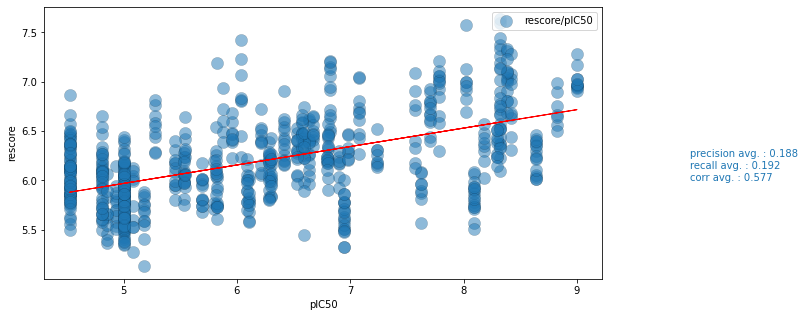

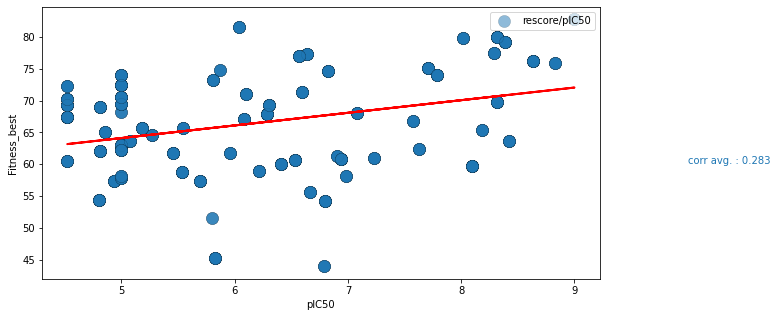

In [4]:
_plt_lgb = return_lgb_plt(res_df)
_plt_lgb.show()
_plt_gold = return_gold_plt(res_df)
_plt_gold.show()


### 0801(date) 44(trainsetsize) xboost ###
### /db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0801_44_3 ###

In [5]:
output_dir = '/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0801_44_3'
res_df = get_result(output_dir)
res_statistics(res_df, criteria='fold_size')


,fold_size,lgb_corr_samples_avg,lgb_corr_samples_std,lgb_corr_samples_var,gold_corr_samples_avg,lgb_corr_total,gold_corr_total,rmse_samples_avg,rmse_total
0,2,0.321719,0.295760,0.087474,0.323991,0.242927,0.327875,1.284931,1.289296
1,3,0.441300,0.202189,0.040880,0.287787,0.368493,0.307631,1.238443,1.243245
2,4,0.558456,0.147604,0.021787,0.263538,0.453066,0.271075,1.173751,1.182227
3,5,0.544250,0.122917,0.015109,0.312097,0.448492,0.315640,1.158032,1.165602
4,6,0.512983,0.169750,0.028815,0.341604,0.420082,0.345748,1.187832,1.196221
5,7,0.541310,0.104802,0.010983,0.302485,0.443500,0.315669,1.191956,1.198101
6,8,0.497963,0.171272,0.029334,0.324911,0.414804,0.328661,1.189372,1.195406
7,9,0.527345,0.132407,0.017532,0.309189,0.453930,0.310862,1.156548,1.165837
8,10,0.587633,0.111849,0.012510,0.359289,0.501833,0.354214,1.170431,1.176919
9,11,0.555210,0.115331,0.013301,0.274267,0.444728,0.274512,1.179998,1.183813


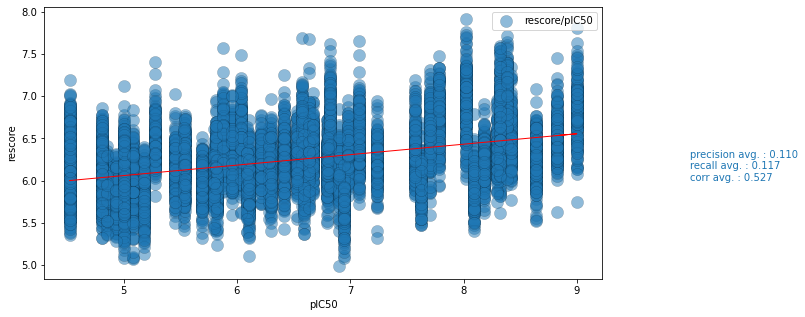

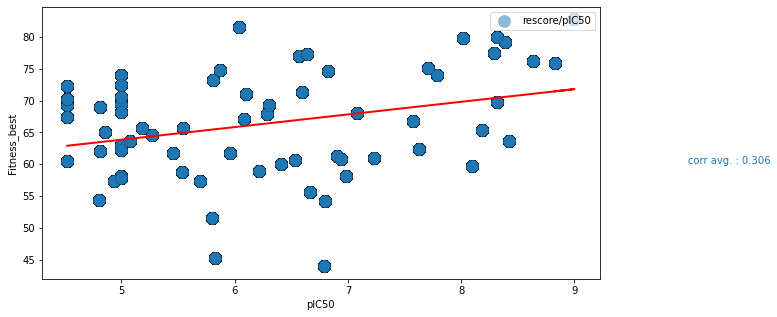

In [6]:
_plt_lgb = return_lgb_plt(res_df)
_plt_lgb.show()
_plt_gold = return_gold_plt(res_df)
_plt_gold.show()


### 0804(date) 44(trainsetsize) feature importance 적용 ###
### /db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0804_ft_44_01 ###

In [7]:
rows = list()

for i in range(0, 10):
    dest_dir = f"/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0804_ft_44_0{i}/"
    imp_ratio = float(f'0.{i}')
    for sample_id in range(0, 30):
        sub_dir = f"{dest_dir}/lgb_sample_{sample_id}/*"
        for a_sub_dir in glob(sub_dir):
            pred = f'{a_sub_dir}/pred.csv'
            if os.path.exists(pred):
                pred_df = pd.read_csv(pred)
                if len(set(pred_df['rescore'].values.tolist())) > 1:
                    trainset_size = pred.split('/')[-2].split('_')[-2]
                    fold_size = int(pred.split('/')[-2].split('_')[-1])
                    _tmpdf = pd.read_csv(pred)
                    corr_res = _tmpdf[['pIC50','rescore']].corr()
                    corr = corr_res['rescore']['pIC50']
                    rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
                    # ROCAUC
                    aswr = _tmpdf['pIC50']>=7
                    pred = _tmpdf['rescore']
                    aswr = [int(item) for item in aswr.values]
                    roc_auc = metrics.roc_auc_score(aswr, pred)
                        # fpr, tpr, thresholds = roc_curve(aswr, pred, pos_label=1)
                        # roc_auc = metrics.auc(fpr,tpr)                    
                    a_row = (imp_ratio, sample_id, trainset_size, fold_size, corr, rmse, roc_auc)
                    rows.append(a_row)
                    
    
df = pd.DataFrame(data= rows,
                  columns= ['imp_feature_ratio',
                            'sample_id',
                            'train_set_size', 
                            'fold_size',
                            'correlation', 
                            'rmse',
                            'roc_auc'])
final_res_df = df
df_data = list()

for imp_feature_ratio in list(set(final_res_df['imp_feature_ratio'].values)):
    _tmp_df_ = final_res_df[ final_res_df['imp_feature_ratio']==imp_feature_ratio ]
    
    corr_mean = _tmp_df_['correlation'].mean()
    corr_std = _tmp_df_['correlation'].std()
    corr_var = _tmp_df_['correlation'].var()
    rmse_mean = _tmp_df_['rmse'].mean()
    roc_auc_mean = _tmp_df_['roc_auc'].mean()
    df_data.append((imp_feature_ratio, corr_mean, corr_std, corr_var, rmse_mean, roc_auc_mean))

lgb_df = pd.DataFrame(data=df_data, 
                      columns=['imp_feature_ratio', 
                               'corr_mean', 
                               'corr_std', 
                               'corr_var', 
                               'rmse_mean', 
                               'roc_auc_mean'])
lgb_df = lgb_df.sort_values(by=['imp_feature_ratio'])
lgb_df['roc_auc_total'] = 0

roc_auc_basket = list()

for i in range(1, 10):
    dest_dir = f"/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0804_ft_44_0{i}/"
    if os.path.exists(dest_dir):        
        imp_ratio = float(f'0.{i}')
        _tmpdf = get_result(dest_dir)
        aswr = _tmpdf['pIC50']>=7
        pred = _tmpdf['rescore']
        aswr = [int(item) for item in aswr.values]
        roc_auc = metrics.roc_auc_score(aswr, pred)
        roc_auc_basket.append(roc_auc)

lgb_df['roc_auc_total'] = roc_auc_basket
lgb_df


,imp_feature_ratio,corr_mean,corr_std,corr_var,rmse_mean,roc_auc_mean,roc_auc_total
0,0.1,0.645899,0.104309,0.010880,1.071102,0.838180,0.798875
3,0.2,0.613640,0.111129,0.012350,1.126015,0.817166,0.741033
2,0.3,0.533146,0.150922,0.022777,1.132843,0.789841,0.733176
1,0.4,0.475272,0.171925,0.029558,1.193036,0.749406,0.679313
4,0.5,0.483632,0.199482,0.039793,1.220219,0.775768,0.673284
5,0.6,0.469002,0.197653,0.039067,1.240834,0.752920,0.686698
6,0.7,0.505583,0.182147,0.033177,1.222209,0.781497,0.748668
7,0.8,0.518707,0.101961,0.010396,1.190828,0.798921,0.733569
8,0.9,0.483191,0.148066,0.021924,1.182711,0.792460,0.739136


### best config - get_result ###

In [8]:
output_dir = "/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0804_ft_44_01/"
res_df = get_result(output_dir)
res_statistics(res_df, criteria='fold_size')

,fold_size,lgb_corr_samples_avg,lgb_corr_samples_std,lgb_corr_samples_var,gold_corr_samples_avg,lgb_corr_total,gold_corr_total,rmse_samples_avg,rmse_total
0,3,0.645899,0.102283,0.010462,0.312527,0.591492,0.313057,1.071102,1.077213


### best config - plot ###

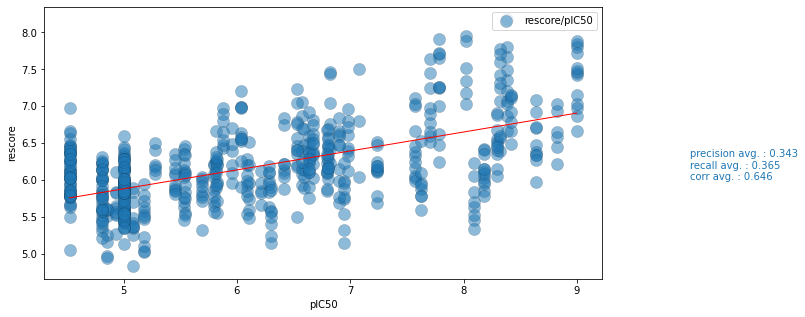

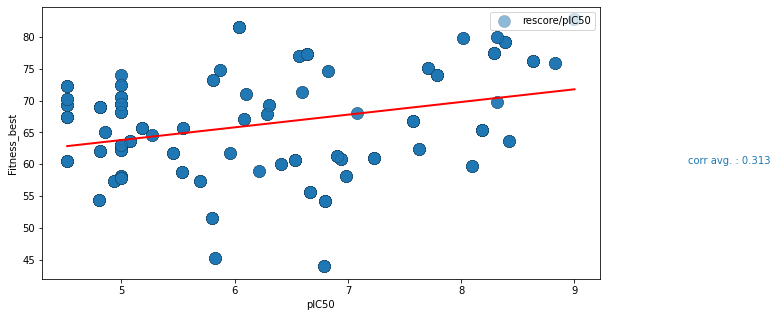

In [17]:
_plt_lgb = return_lgb_plt(res_df)
_plt_lgb.show()
_plt_gold = return_gold_plt(res_df)
_plt_gold.show()


### 0804 feature importance (trainset size : 44 / feature rate 0.1) ###
### 전체 샘플의 GOLD's R ###

In [9]:
rows = list()
idx = 0 
trainset_size = 44
for i in range(1, 2):
    print(f'i : {i}')
    dest_dir = f"/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0804_ft_44_0{i}/"
    imp_ratio = float(f'0.{i}')
    for sample_id in range(0, 30):
        sub_dir = f"{dest_dir}/lgb_sample_{sample_id}/*"
        for a_sub_dir in glob(sub_dir):
            pred = f'{a_sub_dir}/pred.csv'
            if os.path.exists(pred):
                pred_df = pd.read_csv(pred)
                fold_size = pred.split('/')[-2].split('_')[-1]
                fold_size = int(fold_size)
                pred_df = pd.read_csv(pred, index_col=False)
                if len(set(pred_df['rescore'].values.tolist()))>1 and fold_size == 3:
                    pred_df = pred_df.sort_values(by=['pIC50'])

                    titles = pred_df['title'].values.tolist()
                    titles = [title.split('|')[0] for title in titles]
                    pred_df['title'] = titles
                    pred_df['sample_id'] = sample_id
                    pred_df['fold_size'] = fold_size

                    if idx==0:
                        frame_data_frame = pred_df
                        idx=1
                    else:
                        frame_list = frame_data_frame.values.tolist()
                        for a_list in pred_df.values.tolist():
                            frame_list.append(a_list)
                        frame_data_frame = pd.DataFrame(frame_list, columns = frame_data_frame.columns)


i : 1


In [10]:
corr_res = frame_data_frame[['pIC50','rescore']].corr()
corr_res_mean = corr_res['rescore']['pIC50']

corr_gold = frame_data_frame[['pIC50','Gold.PLP.Fitness_best']].corr()
corr_gold_mean = corr_gold['Gold.PLP.Fitness_best']['pIC50']

print(f'corr_res_mean : {corr_res_mean:.3f} | corr_gold_mean : {corr_gold_mean:.3f}')


corr_res_mean : 0.591 | corr_gold_mean : 0.313


### test split sets from woojoo ###

In [9]:
import os
import numpy as np
import pandas as pd
from galapagos_comp.models.lgb import run_lgb
from galapagos_comp.models.pls import run_pls
from galapagos_comp.utils.calc_gold_feature import gold_decomp
from galapagos_comp.utils.calc_glide_feature import glide_decomp
from galapagos_comp.utils.gen_fingerprint import interaction_fingerprint_generator
from galapagos_comp.utils.utils import pic50, get_features
    
receptor_pdb = "/db2/users/sangwonhwang/source/combind_workflow/features/mp00103_prot.pdb"
ligand_sdf = "/db2/users/sangwonhwang/source/combind_workflow/features/mp00103-merge_gold.sdf"
assay_csv = "/db2/users/sangwonhwang/source/galapagos_comp/data/mp00103/MP00103_IC50_galapagos.csv"
output_dir = "/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0731"
vr = 1
model = "lgb"
feature_num = 8
feature_ref = "/db2/users/sangwonhwang/source/galapagos_comp/scripts/feature_importance/feature_importance_avg.csv"
sample_number = 30
trainset_size = 44
fold_size = 3
glide = False

os.makedirs(f'{output_dir}', exist_ok=True)

if glide:
    gold_df = glide_decomp(ligand_sdf)
else:
    gold_df = gold_decomp(ligand_sdf)

# gold_df = gold_df.dropna(axis=1)
if gold_df.isnull().values.any():
    raise Exception('NA is in data frame!!!')
assay_df = pd.read_csv(assay_csv)

ifg = interaction_fingerprint_generator(receptor_pdb, ligand_sdf)
ifp_df = ifg.generate()
types = list(set(ifp_df['label'].values.tolist()))

for atype in types:
    residue_set = list(set(ifp_df[ifp_df['label']==atype]['protein_res'].values))
    if atype == 'contact':
        col_list = [ residue for residue in residue_set ]
    else:
        col_list = [ atype+residue for residue in residue_set ]
    for col_to_add in col_list:
        gold_df[col_to_add] = float(0.0)

for i in range(0, len(gold_df)):
        _pose_df = ifp_df[ifp_df['pose']==i]
        for atype in types:
            _label_df = _pose_df[_pose_df['label']==atype]
            _label = _label_df['label']
            _residue = _label_df['protein_res']
            _score = _label_df['score']
            if len(_label) == len(_residue) == len(_score) != 0:
                for a_pair in zip(_label, _residue, _score):
                    if a_pair[0] == 'contact':
                        gold_df[i:i+1][a_pair[1]] = a_pair[2]
                    else:
                        col = a_pair[0]+a_pair[1]
                        gold_df[i:i+1][col] = a_pair[2]

IC50_scores = list()
pIC50_scores = list()

for idx, title in enumerate(gold_df['title'].values):
    for name in assay_df['Molecule Name'].values:
        if name in title:
            score = assay_df[assay_df['Molecule Name']==name]['IC50 (nM)'].values[0]
            if '>' in score:
                score = score.lstrip('>, ')
            score = float(score)
            IC50_scores.append(score)
            score = pic50(score, unit='nm', digits=3)
            pIC50_scores.append(score)

gold_df['IC50'] = IC50_scores
gold_df['pIC50'] = pIC50_scores

# lgb
# col = gold_df.columns[1:-2].values.tolist()
_ft_ref_df = pd.read_csv(feature_ref)
col = get_features(_ft_ref_df, feature_num)
with open(f'{output_dir}/feature.txt', 'w+') as lf:
    lf.write('\n'.join(col))

# n_pick = int(len(gold_df)*0.75)
n_features_path = f'{output_dir}/feature.txt'
gold_df['title'] = [ item.split('|')[0] for item in gold_df['title'].values.tolist() ]

file = "/db2/users/woojoosim/standigm_first/tools/pos/input/mp_vx_aff/mp103_split.csv"
list_basket = list()
_tmp_list = list()

with open(file, 'r') as f:
    for line in f.readlines():
        if line.startswith('Split'):
            if len(_tmp_list) > 0 :
                list_basket.append(_tmp_list)
            _tmp_list = list()
            _tmp_list.append(line.split('\n')[0])
        else:
            if line != '\n':
                _tmp_list.append(line.split('\n')[0])
                
    list_basket.append(_tmp_list)        

list_basket = [item for idx, item in enumerate(list_basket) if idx%2==0]

for i in range(0, len(list_basket)):
    train_mask = gold_df['title'].isin(np.array(list_basket[i][1:]))
    test_mask = ~gold_df['title'].isin(np.array(list_basket[i][1:]))

    train_df = gold_df[train_mask]
    test_df = gold_df[test_mask]

    print('lenght of train_df : ', len(train_df))
    print('lenght of test_df : ', len(test_df))

/db2/users/sangwonhwang/anaconda3/envs/dev_AB/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/db2/users/sangwonhwang/anaconda3/envs/dev_AB/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


lenght of train_df :  47
lenght of test_df :  20
lenght of train_df :  47
lenght of test_df :  20
lenght of train_df :  47
lenght of test_df :  20
lenght of train_df :  47
lenght of test_df :  20
lenght of train_df :  47
lenght of test_df :  20
lenght of train_df :  47
lenght of test_df :  20
lenght of train_df :  47
lenght of test_df :  20
lenght of train_df :  47
lenght of test_df :  20
lenght of train_df :  47
lenght of test_df :  20
lenght of train_df :  47
lenght of test_df :  20


In [11]:
gold_df.isnull().values.any()

False

### split evaluation from woojoo (fs=3, trainset size=47) ###

In [3]:
output_dir = "/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split"
res_df = get_result(output_dir)
res_statistics(res_df, criteria='fold_size')

,fold_size,lgb_corr_samples_avg,lgb_corr_samples_std,lgb_corr_samples_var,gold_corr_samples_avg,lgb_corr_total,gold_corr_total,rmse_samples_avg,rmse_total
0,3,0.723382,0.060128,0.003615,0.383181,0.662348,0.369492,0.992461,0.99743


In [6]:
rows = list()

dest_dir = f"/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split"
imp_ratio = float(f'0.1')
for sample_id in range(0, 30):
    sub_dir = f"{dest_dir}/lgb_sample_split_{sample_id}/*"
    for a_sub_dir in glob(sub_dir):
        pred = f'{a_sub_dir}/pred.csv'
        if os.path.exists(pred):
            pred_df = pd.read_csv(pred)
            if len(set(pred_df['rescore'].values.tolist())) > 1:
                trainset_size = pred.split('/')[-2].split('_')[-2]
                trainset_size = 47
                fold_size = int(pred.split('/')[-2].split('_')[-1])
                _tmpdf = pd.read_csv(pred)
                corr_res = _tmpdf[['pIC50','rescore']].corr()
                corr = corr_res['rescore']['pIC50']
                rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
                # ROCAUC
                aswr = _tmpdf['pIC50']>=7
                pred = _tmpdf['rescore']
                aswr = [int(item) for item in aswr.values]
                roc_auc = metrics.roc_auc_score(aswr, pred)
                    # fpr, tpr, thresholds = roc_curve(aswr, pred, pos_label=1)
                    # roc_auc = metrics.auc(fpr,tpr)

                a_row = (imp_ratio, sample_id, trainset_size, fold_size, corr, rmse, roc_auc)
                rows.append(a_row)

    
df = pd.DataFrame(data= rows,
                  columns= ['imp_feature_ratio',
                            'sample_id',
                            'train_set_size', 
                            'fold_size',
                            'correlation', 
                            'rmse',
                            'roc_auc'])
final_res_df = df
df_data = list()

for imp_feature_ratio in list(set(final_res_df['imp_feature_ratio'].values)):
    _tmp_df_ = final_res_df[ final_res_df['imp_feature_ratio']==imp_feature_ratio ]
    
    corr_mean = _tmp_df_['correlation'].mean()
    corr_std = _tmp_df_['correlation'].std()
    corr_var = _tmp_df_['correlation'].var()
    rmse_mean = _tmp_df_['rmse'].mean()
    roc_auc_mean = _tmp_df_['roc_auc'].mean()
    df_data.append((imp_feature_ratio, corr_mean, corr_std, corr_var, rmse_mean, roc_auc_mean))

lgb_df = pd.DataFrame(data=df_data, columns=['imp_feature_ratio', 'corr_mean', 'corr_std', 'corr_var', 'rmse_mean', 'roc_auc_mean'])
lgb_df = lgb_df.sort_values(by=['imp_feature_ratio'])
lgb_df['roc_auc_total'] = 0

roc_auc_basket = list()

# dest_dir = f"/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0804_ft_44_0{i}/"
if os.path.exists(dest_dir):
    imp_ratio = float(f'0.1')
    _tmpdf = get_result(dest_dir)
    aswr = _tmpdf['pIC50']>=7
    pred = _tmpdf['rescore']
    aswr = [int(item) for item in aswr.values]
    roc_auc = metrics.roc_auc_score(aswr, pred)
    roc_auc_basket.append(roc_auc)

lgb_df['roc_auc_total'] = roc_auc_basket
lgb_df


,imp_feature_ratio,corr_mean,corr_std,corr_var,rmse_mean,roc_auc_mean,roc_auc_total
0,0.1,0.723382,0.06338,0.004017,0.992461,0.856,0.846533


In [7]:
final_res_df

,imp_feature_ratio,sample_id,train_set_size,fold_size,correlation,rmse,roc_auc
0,0.1,0,47,3,0.829948,0.993495,0.773333
1,0.1,1,47,3,0.739478,1.079994,0.853333
2,0.1,2,47,3,0.754523,0.997940,0.866667
3,0.1,3,47,3,0.734281,1.125927,0.920000
4,0.1,4,47,3,0.744095,0.847539,0.933333
5,0.1,5,47,3,0.791060,0.803447,0.920000
6,0.1,6,47,3,0.699217,0.971968,0.813333
7,0.1,7,47,3,0.660175,1.104001,0.920000
8,0.1,8,47,3,0.648571,1.042891,0.760000
9,0.1,9,47,3,0.632471,0.957412,0.800000


### fold size 10 / split evaluation from woojoo (fs=10, trainset size=47) ###

In [16]:
output_dir = "/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10"
res_df = get_result(output_dir)
res_statistics(res_df, criteria='fold_size')

,fold_size,lgb_corr_samples_avg,lgb_corr_samples_std,lgb_corr_samples_var,gold_corr_samples_avg,lgb_corr_total,gold_corr_total,rmse_samples_avg,rmse_total
0,10,0.709992,0.083888,0.007037,0.383181,0.614433,0.369492,1.029827,1.036283


In [61]:
rows = list()

dest_dir = f"/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10"
imp_ratio = float(f'0.1')
for sample_id in range(0, 30):
    sub_dir = f"{dest_dir}/lgb_sample_split_{sample_id}/*"
    for a_sub_dir in glob(sub_dir):
        pred = f'{a_sub_dir}/pred.csv'
        if os.path.exists(pred):
            print(pred)
            pred_df = pd.read_csv(pred)
            if len(set(pred_df['rescore'].values.tolist())) > 1:
                trainset_size = pred.split('/')[-2].split('_')[-2]
                fold_size = int(pred.split('/')[-2].split('_')[-1])
                _tmpdf = pd.read_csv(pred)
                corr_res = _tmpdf[['pIC50','rescore']].corr()
                corr = corr_res['rescore']['pIC50']
                rmse = np.sqrt(((_tmpdf['pIC50']-_tmpdf['rescore']) ** 2).mean())
                # ROCAUC
                aswr = _tmpdf['pIC50']>=7
                pred = _tmpdf['rescore']
                aswr = [int(item) for item in aswr.values]
                # roc_auc = metrics.roc_auc_score(aswr, pred)
                fpr, tpr, thresholds = metrics.roc_curve(aswr, pred, pos_label=1)
                roc_auc = metrics.auc(fpr,tpr)
                print(f'sample_id: {sample_id} \n| roc_auc : {roc_auc} \n| thresholds : {thresholds}')

                a_row = (imp_ratio, sample_id, trainset_size, fold_size, corr, rmse, roc_auc)
                rows.append(a_row)

    
df = pd.DataFrame(data= rows,
                  columns= ['imp_feature_ratio',
                            'sample_id',
                            'train_set_size', 
                            'fold_size',
                            'correlation', 
                            'rmse',
                            'roc_auc'])
final_res_df = df
df_data = list()

for imp_feature_ratio in list(set(final_res_df['imp_feature_ratio'].values)):
    _tmp_df_ = final_res_df[ final_res_df['imp_feature_ratio']==imp_feature_ratio ]
    
    corr_mean = _tmp_df_['correlation'].mean()
    corr_std = _tmp_df_['correlation'].std()
    corr_var = _tmp_df_['correlation'].var()
    rmse_mean = _tmp_df_['rmse'].mean()
    roc_auc_mean = _tmp_df_['roc_auc'].mean()
    df_data.append((imp_feature_ratio, corr_mean, corr_std, corr_var, rmse_mean, roc_auc_mean))

lgb_df = pd.DataFrame(data=df_data, columns=['imp_feature_ratio', 'corr_mean', 'corr_std', 'corr_var', 'rmse_mean', 'roc_auc_mean'])
lgb_df = lgb_df.sort_values(by=['imp_feature_ratio'])
lgb_df['roc_auc_total'] = 0

roc_auc_basket = list()

# dest_dir = f"/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0804_ft_44_0{i}/"
if os.path.exists(dest_dir):
    imp_ratio = float(f'0.1')
    _tmpdf = get_result(dest_dir)
    aswr = _tmpdf['pIC50']>=7
    pred = _tmpdf['rescore']
    aswr = [int(item) for item in aswr.values]
    roc_auc = metrics.roc_auc_score(aswr, pred)
    roc_auc_basket.append(roc_auc)

lgb_df['roc_auc_total'] = roc_auc_basket
lgb_df


/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10/lgb_sample_split_0/pIC50_60_10/pred.csv
sample_id: 0 
| roc_auc : 0.8133333333333334 
| thresholds : [8.56162734 7.56162734 6.66304576 6.52149864 6.43703522 6.31754696
 6.2784679  6.23885311 6.23339287 5.57048703]
/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10/lgb_sample_split_1/pIC50_60_10/pred.csv
sample_id: 1 
| roc_auc : 1.0 
| thresholds : [7.66732273 6.66732273 6.501237   5.73857638]
/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10/lgb_sample_split_2/pIC50_60_10/pred.csv
sample_id: 2 
| roc_auc : 0.8866666666666667 
| thresholds : [7.24838223 6.24838223 6.19784264 6.15119256 6.15034231 6.08402562]
/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10/lgb_sample_split_3/pIC50_60_10/pred.csv
sample_id: 3 
| roc_auc : 0.92 
| thresholds : [8.53738209 7.53738209 6.82506557 6.33872027 6.31567071 5.

,imp_feature_ratio,corr_mean,corr_std,corr_var,rmse_mean,roc_auc_mean,roc_auc_total
0,0.1,0.709992,0.088426,0.007819,1.029827,0.876667,0.838733


In [63]:
pd.read_csv("/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10/lgb_sample_split_1/pIC50_60_10/pred.csv")

,title,Gold.PLP.Fitness_best,Gold.PLP.PLP_best,Gold.PLP.part.hbond_best,Gold.PLP.part.metal_best,Gold.PLP.part.buried_best,Gold.PLP.part.nonpolar_best,Gold.PLP.part.repulsive_best,Gold.PLP.ligand.clash_best,Gold.PLP.ligand.torsion_best,...,hbond_acceptorA:31:VAL:,hbond_acceptorA:112:SER:,hbond_acceptorA:106:GLU:,hbond_acceptorA:29:GLU:,hbond_acceptorA:110:ALA:,hbond_acceptorA:109:GLY:,hbond_acceptorA:115:ASP:,IC50,pIC50,rescore
0,STD-0002357,80.0272,70.6735,2.8666,-0.0,11.3175,64.1714,5.5324,0.0000,1.0877,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4.8,8.319,6.587163
1,STD-0002329,77.2562,76.3647,1.8834,-0.0,9.8669,66.7230,0.2475,0.0000,0.5804,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,230.4,6.638,6.235935
2,STD-0002330,76.2011,73.1255,2.0000,-0.0,10.2080,63.8013,0.4777,0.0000,1.3691,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,2.3,8.638,6.563297
3,STD-0002337,69.7470,71.2079,0.3445,-0.0,8.0369,65.6570,0.4630,0.0000,2.0145,...,0.000000,0.0,0.0,0.0,0.0,0.0,2.000000,4.8,8.319,6.667323
4,STD-0002368,69.2384,67.9185,-0.0000,-0.0,7.5253,61.7408,0.8138,0.0000,0.4192,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,495.8,6.305,6.267476
5,STD-0002326,68.2187,61.1304,1.7428,-0.0,7.4436,53.3972,0.4327,0.0000,0.4008,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,10000.0,5.000,6.278910
6,STD-0002351,68.0763,63.1234,1.0000,-0.0,3.6280,60.9125,0.3625,0.0000,1.3433,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,83.3,7.079,6.583008
7,STE-2504354,67.9490,68.7833,0.1908,-0.0,9.8790,60.9302,0.7848,0.0000,0.4266,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,519.6,6.284,5.745305
8,STD-0002008,67.1097,62.0914,2.0000,-0.0,4.5916,57.4272,0.7392,0.0000,1.9542,...,0.153995,0.0,0.0,0.0,0.0,0.0,0.000000,821.0,6.086,5.738576
9,STD-0002371,65.0663,60.8387,4.7438,-0.0,6.2559,51.8981,0.3570,0.0000,1.4206,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.221697,14025.0,4.853,5.903866


In [57]:
pd.read_csv("/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10/lgb_sample_split_7/pIC50_60_10/pred.csv")

,title,Gold.PLP.Fitness_best,Gold.PLP.PLP_best,Gold.PLP.part.hbond_best,Gold.PLP.part.metal_best,Gold.PLP.part.buried_best,Gold.PLP.part.nonpolar_best,Gold.PLP.part.repulsive_best,Gold.PLP.ligand.clash_best,Gold.PLP.ligand.torsion_best,...,hbond_acceptorA:31:VAL:,hbond_acceptorA:112:SER:,hbond_acceptorA:106:GLU:,hbond_acceptorA:29:GLU:,hbond_acceptorA:110:ALA:,hbond_acceptorA:109:GLY:,hbond_acceptorA:115:ASP:,IC50,pIC50,rescore
0,STD-0002334,81.5692,74.9458,1.0000,-0.0,9.6523,67.3003,0.6860,0.0000,1.4826,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,913.0,6.040,6.760917
1,STD-0002357,80.0272,70.6735,2.8666,-0.0,11.3175,64.1714,5.5324,0.0000,1.0877,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,4.8,8.319,7.080455
2,STD-0002345,79.8464,74.9465,1.0000,-0.0,10.1779,66.8080,1.3689,0.0000,0.7121,...,1.0,0.0,0.0,0.0,0.783594,0.0,0.000000,9.6,8.018,7.080455
3,STD-0002328,74.8629,71.7386,1.0000,-0.0,10.0220,63.8362,0.4323,0.0000,1.0470,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1339.0,5.873,6.605535
4,STD-0002301,73.9385,73.3625,1.0000,-0.0,8.5252,66.2999,0.5318,0.0000,1.1768,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,10000.0,5.000,6.183145
5,STE-2504314,73.2964,77.5812,-0.0000,-0.0,6.2490,73.6518,0.1109,0.0000,2.7202,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1543.0,5.812,6.264845
6,STD-0002366,72.3561,69.6764,-0.0000,-0.0,8.5020,63.6473,1.4449,0.0000,0.1993,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.070853,30000.0,4.523,6.815226
7,STD-0002337,69.7470,71.2079,0.3445,-0.0,8.0369,65.6570,0.4630,0.0000,2.0145,...,0.0,0.0,0.0,0.0,0.000000,0.0,2.000000,4.8,8.319,7.099381
8,STD-0002351,68.0763,63.1234,1.0000,-0.0,3.6280,60.9125,0.3625,0.0000,1.3433,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,83.3,7.079,6.957972
9,STD-0002305,67.4391,65.0391,1.6999,-0.0,5.4108,67.5089,6.6951,0.0000,1.9375,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,30000.0,4.523,6.144327


In [53]:
_tmpdf = pd.read_csv("/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10/lgb_sample_split_1/pIC50_60_10/pred.csv")
aswr = _tmpdf['pIC50']>=7
pred = _tmpdf['rescore']
aswr = [int(item) for item in aswr.values]
roc_auc = metrics.roc_auc_score(aswr, pred.values.tolist())
roc_auc


1.0

In [47]:
aswr

[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [45]:
pred.values.tolist()

[6.5871634350280335,
 6.235935004604919,
 6.563297163198332,
 6.667322734162841,
 6.267476138877895,
 6.27891032523881,
 6.583007611993186,
 5.745304647510026,
 5.738576376439104,
 5.903866482755837,
 6.501237000971628,
 5.757061617244814,
 6.1091596681811735,
 6.12159175364996,
 6.036620507856559,
 6.055105748662268,
 6.029856126033923,
 5.8830512605229,
 6.024188422387772,
 6.042673663193481]

In [38]:
pd.read_csv("/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0811_split_fs10/lgb_sample_split_1/pIC50_60_10/pred.csv")

,title,Gold.PLP.Fitness_best,Gold.PLP.PLP_best,Gold.PLP.part.hbond_best,Gold.PLP.part.metal_best,Gold.PLP.part.buried_best,Gold.PLP.part.nonpolar_best,Gold.PLP.part.repulsive_best,Gold.PLP.ligand.clash_best,Gold.PLP.ligand.torsion_best,...,hbond_acceptorA:31:VAL:,hbond_acceptorA:112:SER:,hbond_acceptorA:106:GLU:,hbond_acceptorA:29:GLU:,hbond_acceptorA:110:ALA:,hbond_acceptorA:109:GLY:,hbond_acceptorA:115:ASP:,IC50,pIC50,rescore
0,STD-0002357,80.0272,70.6735,2.8666,-0.0,11.3175,64.1714,5.5324,0.0000,1.0877,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4.8,8.319,6.587163
1,STD-0002329,77.2562,76.3647,1.8834,-0.0,9.8669,66.7230,0.2475,0.0000,0.5804,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,230.4,6.638,6.235935
2,STD-0002330,76.2011,73.1255,2.0000,-0.0,10.2080,63.8013,0.4777,0.0000,1.3691,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,2.3,8.638,6.563297
3,STD-0002337,69.7470,71.2079,0.3445,-0.0,8.0369,65.6570,0.4630,0.0000,2.0145,...,0.000000,0.0,0.0,0.0,0.0,0.0,2.000000,4.8,8.319,6.667323
4,STD-0002368,69.2384,67.9185,-0.0000,-0.0,7.5253,61.7408,0.8138,0.0000,0.4192,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,495.8,6.305,6.267476
5,STD-0002326,68.2187,61.1304,1.7428,-0.0,7.4436,53.3972,0.4327,0.0000,0.4008,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,10000.0,5.000,6.278910
6,STD-0002351,68.0763,63.1234,1.0000,-0.0,3.6280,60.9125,0.3625,0.0000,1.3433,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,83.3,7.079,6.583008
7,STE-2504354,67.9490,68.7833,0.1908,-0.0,9.8790,60.9302,0.7848,0.0000,0.4266,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,519.6,6.284,5.745305
8,STD-0002008,67.1097,62.0914,2.0000,-0.0,4.5916,57.4272,0.7392,0.0000,1.9542,...,0.153995,0.0,0.0,0.0,0.0,0.0,0.000000,821.0,6.086,5.738576
9,STD-0002371,65.0663,60.8387,4.7438,-0.0,6.2559,51.8981,0.3570,0.0000,1.4206,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.221697,14025.0,4.853,5.903866


### save images ###

In [2]:
'''
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from glob import glob
from galapagos_comp.utils.utils import get_precision, get_recall

# %matplotlib inline

if __name__ == '__main__':
    rows = list()
    output = '/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0801_44_3'
    idx = 0
    for i in range(0, 20):
        sample_id = i
        trainset_size = 44
        exp_dir = f"{output}/sample_{i}/*"
        for a_sub_dir in glob(exp_dir):
            pred = f'{a_sub_dir}/pred.csv'
            if os.path.exists(pred):
                fold_size = pred.split('/')[-2].split('_')[-1]
                fold_size = int(fold_size)
                pred_df = pd.read_csv(pred, index_col=False)
                if len(set(pred_df['rescore'].values.tolist()))>1 and fold_size == 5:
                # if fold_size != 3:
                    # print('set(rescore) : ',len(set(pred_df['rescore'].values.tolist())))
                    # print('fold_size : ', fold_size)
                    print(f'{pred}  |  {fold_size}')
                    # continue            
                    pred_df = pred_df.sort_values(by=['pIC50'])

                    titles = pred_df['title'].values.tolist()
                    titles = [title.split('|')[0] for title in titles]
                    pred_df['title'] = titles
                    pred_df['sample_id'] = sample_id
                    pred_df['fold_size'] = fold_size

                    _precision = get_precision(pred_df)
                    pred_df['precision'] = _precision
                    _recall = get_recall(pred_df)
                    pred_df['recall'] = _recall

                    if idx==0:
                        frame_data_frame = pred_df
                        idx=1
                    else:
                        frame_list = frame_data_frame.values.tolist()
                        for a_list in pred_df.values.tolist():
                            frame_list.append(a_list)
                        frame_data_frame = pd.DataFrame(frame_list, columns = frame_data_frame.columns)

    _precision = np.mean(frame_data_frame['precision'].values)
    _recall = np.mean(frame_data_frame['recall'].values)

    corr_res = frame_data_frame[['pIC50','rescore']].corr()

    xx = frame_data_frame['pIC50']
    yy = frame_data_frame['rescore']

    fp1 = np.polyfit(xx, yy, 1)
    f1 = np.poly1d(fp1)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(xx, yy, s=150, lw=0.2, alpha=0.5, edgecolors='black', color = '#1f77b4', label='rescore/pIC50')
    # ax.scatter(pred_df['rescore'], pred_df['title'], s=150, lw=0.2, alpha=0.5, edgecolors='black', color = '#00FF00', label='lgb')
    ax.text(10, 6, f'trainset size : {trainset_size} \nprecision avg. : {_precision:.3f} \nrecall avg. : {_recall:.3f}', color = '#1f77b4', size=10)
    ax.set_xlabel('pIC50')
    ax.set_ylabel('rescore')
    ax.legend(loc='upper right')
    plt.plot(xx, f1(xx), lw=1, color='r', label='polyfit')

    # plt.show()
    plt.savefig(f'./mp103_ts_{trainset_size}_si_{sample_id}_fs_{fold_size}.png', dpi=300)
'''

'\nimport os\nimport numpy as np\nimport pandas as pd\nfrom matplotlib import pyplot as plt\n\nfrom glob import glob\nfrom galapagos_comp.utils.utils import get_precision, get_recall\n\n# %matplotlib inline\n\nif __name__ == \'__main__\':\n    rows = list()\n    output = \'/db2/users/sangwonhwang/source/galapagos_comp/scripts/output_sangwon_0801_44_3\'\n    idx = 0\n    for i in range(0, 20):\n        sample_id = i\n        trainset_size = 44\n        exp_dir = f"{output}/sample_{i}/*"\n        for a_sub_dir in glob(exp_dir):\n            pred = f\'{a_sub_dir}/pred.csv\'\n            if os.path.exists(pred):\n                fold_size = pred.split(\'/\')[-2].split(\'_\')[-1]\n                fold_size = int(fold_size)\n                pred_df = pd.read_csv(pred, index_col=False)\n                if len(set(pred_df[\'rescore\'].values.tolist()))>1 and fold_size == 5:\n                # if fold_size != 3:\n                    # print(\'set(rescore) : \',len(set(pred_df[\'rescore\'].value